<a href="https://colab.research.google.com/github/skywalker0803r/Ricky/blob/master/%E7%8E%89%E5%B1%B1AI%E6%AF%94%E8%B3%BD_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import warnings 
warnings.simplefilter('ignore')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
中文map = {'bacno':'歸戶帳號','txkey':'交易序號','locdt':'授權日期','loctm':'授權時間','cano':'交易卡號',
         'contp':'交易類別','etymd':'交易型態','mchno':'特店代號','acqic':'收單行代碼','mcc':'MCC_CODE',
         'conam':'交易金額-台幣(經過轉換)','ecfg':'網路交易註記','insfg':'分期交易註記','iterm':'分期期數',
         'stocn':'消費地國別','scity':'消費城市','stscd':'狀態碼','ovrlt':'超額註記碼','flbmk':'Fallback註記',
         'hcefg':'支付型態','csmcu':'消費地幣別','flg_3dsmk':'3DS交易註記','fraud_ind':'盜刷註記'}

# train

In [3]:
import pandas as pd
train = pd.read_csv("/content/drive/My Drive/玉山人工智慧比賽數據/train_特徵工程完.csv",index_col=0)
print(train.shape)
train.head()

(1521787, 52)


,acqic,bacno,cano,conam,contp,csmcu,ecfg,etymd,flbmk,flg_3dsmk,hcefg,insfg,iterm,loctm,mcc,mchno,ovrlt,scity,stocn,stscd,acqic_stscd_2_count,acqic_etymd_10_count,mchno_stscd_2_count,mchno_etymd_8_count,acqic_iterm_0_count,acqic_stscd_0_count,acqic_ovrlt_0_count,acqic_contp_5_count,cano_stscd_2_count,acqic_hcefg_5_count,acqic_etymd_4_count,acqic_etymd_2_count,acqic_hcefg_1_count,mchno_ovrlt_1_count,acqic_etymd_9_count,acqic_etymd_6_count,acqic_hcefg_2_count,bacno_stscd_2_count,acqic_hcefg_8_count,mchno_hcefg_5_count,acqic_etymd_7_count,acqic_etymd_5_count,acqic_hcefg_3_count,acqic_stscd_1_count,acqic_ovrlt_1_count,acqic_contp_6_count,acqic_iterm_7_count,acqic_iterm_1_count,acqic_hcefg_6_count,acqic_iterm_4_count,txkey,fraud_ind
0,6862,112785,37846,16158,5,0,0,0,0,0,5,0,0,61954,457,59034,0,0,102,0,170.0,0,43.0,0.0,126507.0,126337.0,124910.0,126507.0,0,124413.0,0.0,0.0,0.0,605.0,0.0,0.0,0.0,0,0.0,40788.0,0,0.0,0,0,1597.0,0.0,0.0,0.0,907.0,0.0,516056,0
1,0,133951,45476,13693,5,0,0,2,0,0,0,0,0,38216,451,0,0,5795,102,0,0.0,0,1.0,12.0,61355.0,61034.0,60847.0,61190.0,0,410.0,0.0,57060.0,2582.0,504.0,0.0,0.0,814.0,0,201.0,2201.0,0,0.0,0,156,508.0,0.0,0.0,0.0,215.0,0.0,4376,0
2,6862,15350,187354,16158,5,0,0,0,0,0,5,0,0,54640,457,59034,0,0,102,0,170.0,0,43.0,0.0,126507.0,126337.0,124910.0,126507.0,0,124413.0,0.0,0.0,0.0,605.0,0.0,0.0,0.0,0,0.0,40788.0,0,0.0,0,0,1597.0,0.0,0.0,0.0,907.0,0.0,483434,0
3,6697,156492,29812,40413,5,62,0,5,0,0,5,0,0,62128,247,50185,0,3267,102,0,38.0,0,0.0,0.0,222072.0,255135.0,252224.0,240122.0,0,246548.0,77704.0,56928.0,6230.0,13.0,3256.0,0.0,399.0,0,961.0,991.0,0,79711.0,17,53,3002.0,5194.0,589.0,15482.0,945.0,2101.0,1407164,0
4,5959,105534,80881,25962,5,62,0,4,0,0,5,0,0,65231,263,93290,0,5795,102,0,6.0,0,0.0,0.0,159855.0,159838.0,158259.0,133427.0,0,157122.0,71468.0,38753.0,1518.0,0.0,1929.0,0.0,113.0,0,137.0,48.0,0,32943.0,22,11,1596.0,0.0,0.0,0.0,928.0,0.0,1051004,0


# test

In [4]:
test = pd.read_csv("/content/drive/My Drive/玉山人工智慧比賽數據/test_特徵工程完.csv",index_col=0)
test_txkey = test["txkey"]
print(test.shape)
test.head()

(421665, 51)


,acqic,bacno,cano,conam,contp,csmcu,ecfg,etymd,flbmk,flg_3dsmk,hcefg,insfg,iterm,loctm,mcc,mchno,ovrlt,scity,stocn,stscd,acqic_stscd_2_count,acqic_etymd_10_count,mchno_stscd_2_count,mchno_etymd_8_count,acqic_iterm_0_count,acqic_stscd_0_count,acqic_ovrlt_0_count,acqic_contp_5_count,cano_stscd_2_count,acqic_hcefg_5_count,acqic_etymd_4_count,acqic_etymd_2_count,acqic_hcefg_1_count,mchno_ovrlt_1_count,acqic_etymd_9_count,acqic_etymd_6_count,acqic_hcefg_2_count,bacno_stscd_2_count,acqic_hcefg_8_count,mchno_hcefg_5_count,acqic_etymd_7_count,acqic_etymd_5_count,acqic_hcefg_3_count,acqic_stscd_1_count,acqic_ovrlt_1_count,acqic_contp_6_count,acqic_iterm_7_count,acqic_iterm_1_count,acqic_hcefg_6_count,acqic_iterm_4_count,txkey
1521787,6862,162489,116168,16158,5,0,0,0,0,0,5,0,0,77950,457,59060,0,0,102,0,170.0,0,10.0,0.0,126507.0,126337.0,124910.0,126507.0,2,124413.0,0.0,0.0,0.0,113.0,0.0,0.0,0.0,2,0.0,5125.0,0,0.0,0,0,1597.0,0.0,0.0,0.0,907.0,0.0,592489
1521788,6862,162489,116168,16158,5,0,0,0,0,0,5,0,0,79549,457,59060,0,0,102,0,170.0,0,10.0,0.0,126507.0,126337.0,124910.0,126507.0,2,124413.0,0.0,0.0,0.0,113.0,0.0,0.0,0.0,2,0.0,5125.0,0,0.0,0,0,1597.0,0.0,0.0,0.0,907.0,0.0,592452
1521789,6862,162489,116168,16158,5,0,0,0,0,0,5,0,0,60355,457,59060,0,0,102,0,170.0,0,10.0,0.0,126507.0,126337.0,124910.0,126507.0,2,124413.0,0.0,0.0,0.0,113.0,0.0,0.0,0.0,2,0.0,5125.0,0,0.0,0,0,1597.0,0.0,0.0,0.0,907.0,0.0,590212
1521790,6862,162489,116168,16158,5,0,0,0,0,0,5,0,0,60296,457,59060,0,0,102,0,170.0,0,10.0,0.0,126507.0,126337.0,124910.0,126507.0,2,124413.0,0.0,0.0,0.0,113.0,0.0,0.0,0.0,2,0.0,5125.0,0,0.0,0,0,1597.0,0.0,0.0,0.0,907.0,0.0,590209
1521791,6862,162489,116168,16158,5,0,0,0,0,0,5,0,0,77933,457,59060,0,0,102,0,170.0,0,10.0,0.0,126507.0,126337.0,124910.0,126507.0,2,124413.0,0.0,0.0,0.0,113.0,0.0,0.0,0.0,2,0.0,5125.0,0,0.0,0,0,1597.0,0.0,0.0,0.0,907.0,0.0,592488


# 定義 features & target

In [5]:
features = train.drop(['fraud_ind','txkey'],axis=1).columns.tolist()
cat_features = features[:20]
y_name = 'fraud_ind'
print(len(features),features)
print(len(cat_features),cat_features)
print(len([y_name]),[y_name])

50 ['acqic', 'bacno', 'cano', 'conam', 'contp', 'csmcu', 'ecfg', 'etymd', 'flbmk', 'flg_3dsmk', 'hcefg', 'insfg', 'iterm', 'loctm', 'mcc', 'mchno', 'ovrlt', 'scity', 'stocn', 'stscd', 'acqic_stscd_2_count', 'acqic_etymd_10_count', 'mchno_stscd_2_count', 'mchno_etymd_8_count', 'acqic_iterm_0_count', 'acqic_stscd_0_count', 'acqic_ovrlt_0_count', 'acqic_contp_5_count', 'cano_stscd_2_count', 'acqic_hcefg_5_count', 'acqic_etymd_4_count', 'acqic_etymd_2_count', 'acqic_hcefg_1_count', 'mchno_ovrlt_1_count', 'acqic_etymd_9_count', 'acqic_etymd_6_count', 'acqic_hcefg_2_count', 'bacno_stscd_2_count', 'acqic_hcefg_8_count', 'mchno_hcefg_5_count', 'acqic_etymd_7_count', 'acqic_etymd_5_count', 'acqic_hcefg_3_count', 'acqic_stscd_1_count', 'acqic_ovrlt_1_count', 'acqic_contp_6_count', 'acqic_iterm_7_count', 'acqic_iterm_1_count', 'acqic_hcefg_6_count', 'acqic_iterm_4_count']
20 ['acqic', 'bacno', 'cano', 'conam', 'contp', 'csmcu', 'ecfg', 'etymd', 'flbmk', 'flg_3dsmk', 'hcefg', 'insfg', 'iterm', 'lo

# 切分 訓練集 跟 驗證集

In [6]:
from sklearn.model_selection import train_test_split
train,val = train_test_split(train ,test_size=0.2 ,random_state=42)
print(train.shape)
print(val.shape)

(1217429, 52)
(304358, 52)


# train

[1]	train's xentropy: 0.0459068	train's f1: 0.330417	val's xentropy: 0.0467649	val's f1: 0.318261
Training until validation scores don't improve for 30 rounds.
[2]	train's xentropy: 0.0414352	train's f1: 0.367188	val's xentropy: 0.0424356	val's f1: 0.349858
[3]	train's xentropy: 0.0390297	train's f1: 0.388214	val's xentropy: 0.0401458	val's f1: 0.36701
[4]	train's xentropy: 0.0373158	train's f1: 0.394213	val's xentropy: 0.0384422	val's f1: 0.374324
[5]	train's xentropy: 0.0359174	train's f1: 0.436313	val's xentropy: 0.0371512	val's f1: 0.419953
[6]	train's xentropy: 0.0346522	train's f1: 0.474432	val's xentropy: 0.0360091	val's f1: 0.456153
[7]	train's xentropy: 0.0336201	train's f1: 0.483907	val's xentropy: 0.0350575	val's f1: 0.463027
[8]	train's xentropy: 0.0326027	train's f1: 0.506278	val's xentropy: 0.0340934	val's f1: 0.480694
[9]	train's xentropy: 0.0315526	train's f1: 0.543287	val's xentropy: 0.0331104	val's f1: 0.519632
[10]	train's xentropy: 0.0308094	train's f1: 0.550342	val

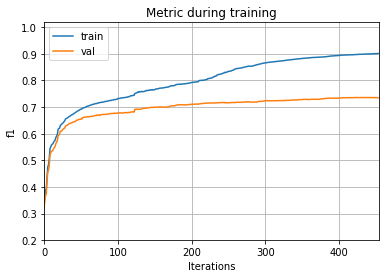

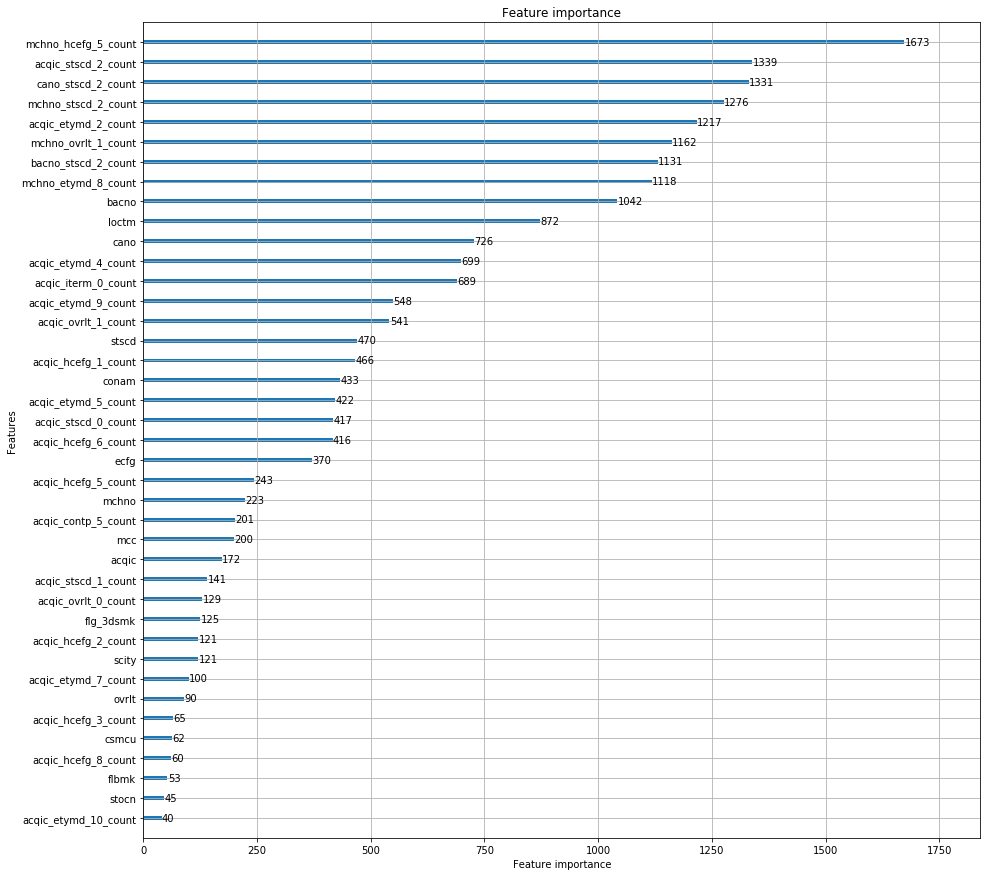

In [7]:
import lightgbm
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import numpy as np

# f1 score
def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat)
    return 'f1', f1_score(y_true, y_hat), True

# 超參數  
parameters = {
    'boosting_type':'gbdt',
    'n_estimators':100,
    'objective': 'cross_entropy',
    'metric': 'cross_entropy',
    'num_iterations': 500,
    'learning_rate': 0.1,
    'max_depth':7,
    'num_leaves':50,
    'feature_fraction': 0.7,
    'tree_learner': 'data',
    "is_unbalance": True,
    "early_stopping_round": 30,
    #'min_child_samples':20,
    #'min_child_weight': 0.001,
}

# train data
train_data = lightgbm.Dataset(train[features], 
                              label = train[y_name],
                              categorical_feature = cat_features)
# val data
val_data = lightgbm.Dataset(val[features], 
                            label = val[y_name],
                            categorical_feature = cat_features)

# training
evals_result = {}
model = lightgbm.train(parameters,
                       train_data, 
                       valid_sets=[val_data, train_data],
                       valid_names=['val', 'train'], 
                       feval = lgb_f1_score,
                       evals_result = evals_result)

# plt 1
lightgbm.plot_metric(evals_result, metric='f1')
plt.show()

# plt 2
ax = lightgbm.plot_importance(model, max_num_features=40, figsize=(15,15))
plt.show()

# F1 report

In [8]:
from sklearn.metrics import classification_report 

y_pred = pd.Series(model.predict(val[features])).apply(round)

print(classification_report(val[y_name],y_pred,target_names=['0','1']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    300267
           1       0.82      0.67      0.74      4091

    accuracy                           0.99    304358
   macro avg       0.91      0.83      0.87    304358
weighted avg       0.99      0.99      0.99    304358



# 產生submission

In [9]:
submission = pd.DataFrame({"txkey":test_txkey,
                           "fraud_ind":model.predict(test[features])})

# to [0,1] 
submission["fraud_ind"] = submission["fraud_ind"].apply(round)

# value_counts
print(submission["fraud_ind"].value_counts())
submission.head()

0    416638
1      5027
Name: fraud_ind, dtype: int64


,txkey,fraud_ind
1521787,592489,0
1521788,592452,0
1521789,590212,0
1521790,590209,0
1521791,592488,0


# 保存

In [0]:
submission.to_csv("./submission_28.csv")

In [11]:
print(submission["fraud_ind"].value_counts())

0    416638
1      5027
Name: fraud_ind, dtype: int64
